<a href="https://colab.research.google.com/github/one-2/comp9418/blob/main/COMP9418_W00_Graph_Representation_Traversal_MST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UNSW-COMP9418/Week00/blob/main/COMP9418_W00_Graph_Representation_Traversal_MST.ipynb)

# Graph Representation, Traversal and MST

**COMP9418 W00 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista and Jeremy Gillen
- Last Update 6th September 2022

In this week's tutorial, we will review key concepts and algorithms for graph representation, traversal, and Minimum Spanning Trees (MSTs) that will be useful throughout the course.

## Technical prerequisites

We will use Jupyter Notebooks in the practical part of the tutorials. There are three main ways to run these notebooks:

1. *Google Colab*. The links available in WebCMS will open the course notebooks in [Google Colab](https://colab.research.google.com/). Google Colab has all the packages necessary to run these notebooks, so no installation is required. **This is our prefered approach**.

2. *CSE VLAB*. We have installed the necessary packages in the CSE computers. You have to copy the notebook to your CSE account in VLAB to execute it. There are two possibilities to access VLAB. The most recommended is installing a [VNC software](https://taggi.cse.unsw.edu.au/FAQ/Really_quick_guide_to_VLAB/) on your computer. Alternatively, you can access these computers through a web interface using [CSE VLAB Gateway](https://vlabgateway.cse.unsw.edu.au/).

3. *Your computer*. If you do not have Jupyter installed on your computer, we recommend installing [Anaconda](https://www.anaconda.com/distribution). Anaconda conveniently installs Python, the Jupyter Notebook, and other commonly used packages for scientific computing and data science. To render a graphical visualization of some graphs in this notebook, you also need to [install Graphviz](http://www.graphviz.org/download). If you have conda installed in your computer, you can try the command ```conda install python-graphviz``` directly. From our experience, Graphviz can be a bit troublesome to install on certain systems. For instance, ```conda install python-graphviz``` often does not work on Linux systems, and we did not have any success using ```pip3 install graphviz``` on most systems, so do *not* use ```pip3```.

Once we have done all that, we import Graphviz and heapq modules for later use.

In [19]:
# Visualise our graph
import graphviz
# Priority queue for Prim algorithm
import heapq as pq

## Representing graphs

We will not use any particular library for representing graphs in Python. Instead, we will represent a graph structure as a dictionary, where the keys are the nodes of the graph. For each key, the corresponding value is a list. The list contains the nodes that are directly connected to this node.

For instance, the following graph:

![Graph example](https://raw.githubusercontent.com/UNSW-COMP9418/Week00/main/img/example_graph.png "Graph example")

can be represented as

```
graph = {
    0: [2],
    1: [0],
    2: [1],
    3: [1, 2],
}
```

This representation is an adjacency list. If you'd like to read more about this style of graphs, there is more
[information on the Python website](https://www.python.org/doc/essays/graphs/).

### Exercise

Now, it is your turn. Represent the following directed graph using the suggested adjacency list representation.

![Graph exercise](https://raw.githubusercontent.com/UNSW-COMP9418/Week00/main/img/exercise_graph.png "Graph exercise")

In [20]:
graph = {
    0: [3],
    1: [0, 4],
    2: [1, 4],
    3: [1],
    4: [3],
    5: [2, 4],
}

## Graphviz

We can use the Graphviz library to visually inspect our graphs.

The following code will convert your digraph to a Graphviz object and render it.

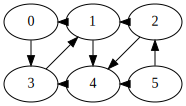

In [21]:
dot = graphviz.Digraph(engine="neato", comment='Direct graph example')
dot.attr(overlap="false", splines="true")

# List of positions for each node
# We use node positions to replicate the previous figure
# This can be removed if the nodes do not need to be presented in a specific order
pos = {
    0: '0,1!',
    1: '1,1!',
    2: '2,1!',
    3: '0,0!',
    4: '1,0!',
    5: '2,0!',
}

for v in graph.keys():
    dot.node(str(v), pos=pos[v])
    # dot.node(str(v))              # Use this line instead of the previous one to position the nodes in random order

for v in graph.keys():
    for w in graph[v]:
        dot.edge(str(v), str(w))

dot

## Graph class

To keep our code clean and put all of the graph-related functions in one place, we can wrap this graph data structure in a class.

In [22]:
class Graph:
    def __init__(self, adj_list=None):
        self.adj_list = dict()
        if adj_list is not None:
            self.adj_list = adj_list.copy() # dict with graph's adjacency list
        self.colour = dict()

In [23]:
class Graph(Graph):
    def show(self, directed=True, positions=None):
        """
        Prints a graphical visualisation of the graph usign GraphViz
        arguments:
            `directed`, True if the graph is directed, False if the graph is undirected
            `pos: dictionary`, with nodes as keys and positions as values
        return:
            GraphViz object
        """
        if directed:
            dot = graphviz.Digraph(engine="neato", comment='Directed graph')
        else:
            dot = graphviz.Graph(engine="neato", comment='Undirected graph', strict=True)
        dot.attr(overlap="false", splines="true")
        for v in self.adj_list:
            if positions is not None:
                dot.node(str(v), pos=positions[v])
            else:
                dot.node(str(v))
        for v in self.adj_list:
            for w in self.adj_list[v]:
                dot.edge(str(v), str(w))

        return dot

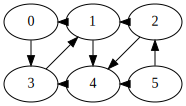

In [24]:
G = Graph(graph)
G.show(positions=pos)

## Depth-first search

Let's implement the DFS search. We will provide the code for you. Later on, you will extend it to implement other algorithms. We will use a colouring scheme for nodes.

Initially, all nodes are "white," indicating they have not been processed yet. When we first visit a node, we recolour it as "grey". Finally, the node becomes "black" when we have processed all its outgoing edges, and we are ready to backtrack to the previous node.

In [25]:
class Graph(Graph):
    def _dfs_r(self, v): # This is the main DFS recursive function
        """
        argument
        `v`, next vertex to be visited
        `colour`, dictionary with the colour of each node
        """
        print('Visiting: ', v)
        self.colour[v] = 'grey' # Visited vertices are coloured 'grey'
        for w in self.adj_list[v]: # Let's visit all outgoing edges from v
            if self.colour[w] == 'white': # To avoid loops, we check if the next vertex hasn't been visited yet
                self._dfs_r(w)
        self.colour[v] = 'black' # When we finish the for loop, we know we have visited all nodes from v. It is time to turn it 'black'

    def dfs(self, start): # This is an auxiliary DFS function to create and initialize the colour dictionary
        """
        argument
        `start`, starting vertex
        """
        self.colour = {node: 'white' for node in self.adj_list.keys()} # Create a dictionary with keys as node numbers and values equal to 'white'
        self._dfs_r(start)
        return self.colour # We can return colour dictionary. It is useful for some operations, such as detecting connected components

We can now test your graph representation. If you represented the graph correctly, a DFS starting at node 0 should visit all vertices but nodes 2 and 5. Notice, there is no path between node 0 and nodes 2 and 5.

In [26]:
G = Graph(graph)
G.dfs(0)

Visiting:  0
Visiting:  3
Visiting:  1
Visiting:  4


{0: 'black', 1: 'black', 2: 'white', 3: 'black', 4: 'black', 5: 'white'}

A modification of the algorithm can make sure it searches all nodes, even if they are disconnected from other nodes. The idea is to restart the recursive DFS search for each white node until all nodes become black.

In [27]:
class Graph(Graph):
    def dfs_all(self): # This is an auxiliary DFS function to create and initialize the colour dictionary
        """
        argument
        `start`, starting vertex
        """
        self.colour = {node: 'white' for node in self.adj_list.keys()} # Create a dictionary with keys as node numbers and values equal to 'white'
        for start in self.colour.keys():
            if self.colour[start] == 'white':
                self._dfs_r(start)

In [28]:
G = Graph(graph)
G.dfs_all()

Visiting:  0
Visiting:  3
Visiting:  1
Visiting:  4
Visiting:  2
Visiting:  5


## Finding Cycles in Directed Graphs

Our second task is to determine if a graph has cycles. During a DFS, a cycle can be found by testing if we have reached a grey node. Usually, we stop when we first observe a cycle. Therefore, we need to modify the DFS procedure to return a boolean.

### Exercise

Now, it is your turn to modify the code below to detect cycles in directed graphs.

In [29]:
class Graph(Graph):
    # This is the main recursive function
    def _find_cycle_r(self, v):
        """
        argument
        `v`, next vertex to be visited
        """
        print('Visiting: ', v)

        # insert your code here
        # print a debug message such as
        # print(v, w, 'Cycle detected')
        # and return True
        # when you detect a cycle.

        return False

    # This is an auxiliary function to create and initialize the colour dictionary
    def find_cycle(self):
        """
        argument
        `v`, starting vertex
        """
        self.colour = dict([(node, 'white') for node in self.adj_list.keys()])
        for start in self.colour.keys():
            if self.colour[start] == 'white':
                if self._find_cycle_r(start):
                    return True
        return False

#######################################
# Test code
#######################################
test_graph1 = {
    0: [1],
    1: [2],
    2: [3],
    3: [4],
    4: [5],
    5: [0],
}

test_graph2 = {
    0: [1,4],
    1: [2],
    2: [4],
    3: [],
    4: [5],
    5: [3],
}

test_graph3 = {
    0: [1],
    1: [2],
    2: [],
    3: [4],
    4: [5],
    5: [3],
}

print ('Test graph 1')
G1 = Graph(test_graph1)
G1.find_cycle()
print ('Test graph 2')
G2 = Graph(test_graph2)
G2.find_cycle()
print ('Test graph 3')
G3 = Graph(test_graph3)
G3.find_cycle()

Test graph 1
Visiting:  0
Visiting:  1
Visiting:  2
Visiting:  3
Visiting:  4
Visiting:  5
Test graph 2
Visiting:  0
Visiting:  1
Visiting:  2
Visiting:  3
Visiting:  4
Visiting:  5
Test graph 3
Visiting:  0
Visiting:  1
Visiting:  2
Visiting:  3
Visiting:  4
Visiting:  5


False

If your implementation is correct and you included a message when the cycle is detected, then you should see the following output:

```
Test graph 1
Visiting:  0
Visiting:  1
Visiting:  2
Visiting:  3
Visiting:  4
Visiting:  5
5 0 Cycle detected
Test graph 2
Visiting:  0
Visiting:  1
Visiting:  2
Visiting:  4
Visiting:  5
Visiting:  3
Test graph 3
Visiting:  0
Visiting:  1
Visiting:  2
Visiting:  3
Visiting:  4
Visiting:  5
5 3 Cycle detected
```

We can now test your implementation in the exercise graph.

In [30]:
G = Graph(graph)
G.find_cycle()

Visiting:  0
Visiting:  1
Visiting:  2
Visiting:  3
Visiting:  4
Visiting:  5


False

It should show one of the following cycles: 0-3-1 or 1-4-2, depending on the order you entered the node numbers in the adjacency list.

# Topological Sort

The topological sort can be obtained by merely inserting the nodes into a stack when they become black. We use the stack to reverse the order of the nodes when printing the result. By doing so, the edges are directed from left to right.

## Exercise

Let's implement the topological sort. It is an almost trivial modification of your DFS procedure. We have started the code for you to create a stack to store the sorted nodes.

In [31]:
class Graph(Graph):
    # This is the recursive function that visits the nodes according to depth-first search and appends the black nodes
    # to the end of a `stack` list.
    def _topological_sort_r(self, v):
        """
        argument
        `v`, current vertex
        """

        # TODO: Fill in this function
        ...


    # This is main function that prepares for the recursive function. It first colours all nodes as 'white' and call the
    # recursive function for an arbitrary node. When the recursive function returns, if we have any remaining 'white'
    # nodes, we call the recursive function again for these nodes.
    def topological_sort(self):
        """
        argument
        `G`, an adjacency list representation of a graph
        return a list with the topological order of the graph G
        """
        # We start with an empty stack
        self.stack = []
        # Colour is dictionary that associates node keys to colours. The colours are 'white', 'grey' and 'black'.
        self.colour = {node: 'white' for node in self.adj_list.keys()}
        # We call the recursive function to visit a first node. When the function returns, if there are any white
        # nodes remaining, we call the function again for these white nodes
        for start in self.adj_list.keys():
            # If the node is 'white' we call the recursive function to vists the nodes connected to it in DFS order
            if self.colour[start] == 'white':
                # This is a call to topologicalSort_r
                self._topological_sort_r(start)
        # We need to reverse the list, we use a little trick with list slice
        return self.stack[::-1]


#######################################
# Test code
#######################################

test_graph2 = {
    0: [1,4],
    1: [2],
    2: [4],
    3: [],
    4: [5],
    5: [3],
}

G2 = Graph(test_graph2)
print("Topological sort:")
print(G2.topological_sort())

Topological sort:
[]


If your implementation is correct, then you should see the following output:

```
Topological sort:
[0, 1, 2, 4, 5, 3]
```

Now, let's execute your code. First, we need a new DAG, since our example has cycles and the topological ordering only makes sense for acyclic graphs.

In [32]:
graph = {
    0: [1, 4],
    1: [2, 4],
    2: [5],
    3: [0, 4],
    4: [5],
    5: [],
}

G = Graph(graph)
G.topological_sort()

[]

Let's visualise the test graph again, just to remember its topology.

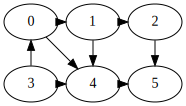

In [33]:
G.show(positions=pos)

We can use graphViz to visualize the topological sort output graphically to confirm our code is correct.

In [34]:
# We use the neato engine since it allow to position the nodes
dot = graphviz.Digraph(engine="neato", comment='Topological sort')
# This line will avoid the edges to cross over the nodes
dot.attr(overlap="false", splines="true")

s = G.topological_sort()

# Create nodes in sequence positions determined by the stack s
for i, v in enumerate(s, 1):
    dot.node(str(v), pos=str(i)+',0!')

# Create edges
for v in s:
    for w in graph[v]:
        dot.edge(str(v), str(w))

dot

# Transpose Graph

Transposition is an operation over a directed graph $G$ that results in another directed graph on the same set of vertices with all of the edges reversed. The following figure illustrates this process, with a graph $G$ on the left side and its transpose $G^T$ on the right side:

![Transpose graph](https://raw.githubusercontent.com/UNSW-COMP9418/Week00/main/img/Transpose_graph.png "Transpose Graph")


## Exercise

Implement the transpose operation over our graph representation. Take a graph as input and produce its transpose as output.

In [35]:
class Graph(Graph):
    def transpose(self):
        """
        argument
        `G`, an adjacency list representation of a graph
        """
        gt = dict((v, []) for v in self.adj_list)
        # TODO
        ...
        return Graph(gt)

Let's write some code for testing. First, we define the same test graph as the figure above. We will call our transpose_graph routine and use the Graphviz library to plot the transposed graph. We have done the code for you below. You can compare the output with the figure above to check if your code is correct.

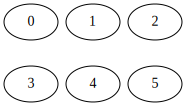

In [36]:
#######################################
# Test code
#######################################

test_graph = {
    0: [3],
    1: [0, 4],
    2: [1, 4],
    3: [1],
    4: [3, 5],
    5: [2],
}

pos = {
    0: '0,1!',
    1: '1,1!',
    2: '2,1!',
    3: '0,0!',
    4: '1,0!',
    5: '2,0!',
}

G = Graph(test_graph)
GT = G.transpose()
GT.show(positions=pos)

# Minimum Spanning Trees

A minimum spanning tree (MST) is an operation on weighted undirected graphs. We receive a graph $G=(V,E)$ and we should return the spanning tree of $G$ that has a minimum cost.

A spanning tree is a graph with the same set of vertices $V$ of $G$, but with potentially fewer edges. A spanning tree is a graph with no cycles. If $G$ has $n$ edges, its spanning tree must have $n-1$ edges.

The minimum spanning tree is the spanning tree whose sum of edge weights is the smallest among all spanning trees.

The next figure shows a weighted undirect graph is its corresponding MST.

![MST](https://raw.githubusercontent.com/UNSW-COMP9418/Week00/main/img/spanning_tree.png "MST")

Let's start by augmenting our graph representation to support weighted edges and adding methods that enable us to add nodes and edges to the graph easily. For later convenience, we will also add functions to remove nodes, iterate over all nodes, and get the children of a node.

In [37]:
class Graph(Graph):
    def __init__(self, adj_list=None):
        self.adj_list = dict()
        if adj_list is not None:
            self.adj_list = adj_list.copy() # dict with graph's adjacency list
        self.colour = dict()
        self.edge_weights = dict() # maps a tuple (node1, node2) to a number

    def __len__(self):
        '''
        return the number of nodes in the graph
        '''
        return len(self.adj_list.keys())

    def __iter__(self):
        '''
        Let a user iterate over the nodes of the graph, like:
        for node in graph:
            print(node)
        '''
        return iter(self.adj_list.keys())

    def children(self, node):
        '''
        Return a list of children of a node
        '''
        return self.adj_list[node]

    def add_node(self, name):
        '''
        This method adds a node to the graph.
        '''
        if name not in self.adj_list:
            self.adj_list[name] = []

    def remove_node(self, name):
        '''
        This method removes a node, and any edges to or from the node
        '''
        for node in self.adj_list.keys():
            if name in self.adj_list[node]:
                self.adj_list[node].remove(name)
        del self.adj_list[name]

    def add_edge(self, node1, node2, weight=1, directed=True):
        '''
        This function adds an edge. If directed is false, it adds an edge in both directions
        '''
        # in case they don't already exist, add these nodes to the graph
        self.add_node(node1)
        self.add_node(node2)

        self.adj_list[node1].append(node2)
        self.edge_weights[(node1,node2)] = weight

        if not directed:
            self.adj_list[node2].append(node1)
            self.edge_weights[(node2,node1)] = weight

    def copy(self):
        '''
        This function creates a copy of the graph object
        '''
        return copy.deepcopy(self)

    def convert_to_undirected(self):
        '''
        Assumes that the graph is directed, and creates a reversed version of every edge
        '''
        G = self.copy()
        GT = self.transpose()
        for vertex in self:
            G.adj_list[vertex] = G.adj_list[vertex] + GT.adj_list[vertex]
        return G

    def remove_outgoing_from(self, node):
        '''
        Removes all outgoing edges from node
        '''
        self.adj_list[node] = []

# Reinitialise graph G
G = Graph(graph)

### Example usage
print(f"The number of nodes in the graph is {len(G)}")

print("List of all nodes in the graph:")
for node in G:
    print(node)

# check if 0 is a child of 1
if 0 in G.children(1):
    print("0 is child of 1")
else:
    print("0 is not child of 1")

print(f"Children of 1 are {G.children(1)}")

The number of nodes in the graph is 6
List of all nodes in the graph:
0
1
2
3
4
5
0 is not child of 1
Children of 1 are [2, 4]


## Exercise

Represent the graph on the left side of the previous figure using the proposed augmented representation. We have started and completed the first row.

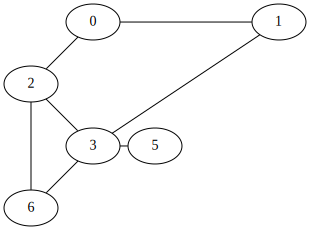

In [38]:
g = Graph()
g.add_edge(0,2,weight=4,directed=False)
g.add_edge(0,1,weight=24,directed=False)
g.add_edge(2,3,weight=6,directed=False)
g.add_edge(2,6,weight=16,directed=False)
g.add_edge(3,6,weight=8,directed=False)
g.add_edge(3,5,weight=5,directed=False)
g.add_edge(3,1,weight=23,directed=False)
# TODO: add the rest of the edges
...

#######################################
# Test code
#######################################
pos = {
    0: '1,3!',
    1: '4,3!',
    2: '0,2!',
    3: '1,1!',
    4: '3,1!',
    5: '2,1!',
    6: '0,0!',
    7: '4,0!',
}
g.show(directed=False, positions=pos)

## Exercise

Now, let's implement the Prim algorithm. The general idea is to start the search from a node `s`. Initially, only nodes directly connected to `s` are considered. We use a priority queue to sort these nodes according to the edge weight. The priority queue is implemented with a binary heap data structure using Python's [heapq](https://docs.python.org/3/library/heapq.html) module. The node `u` with the smallest cost connecting to `s` is removed from the priority queue and inserted into the MST. The search expands to include the vertices that directly connect to `u`. These nodes are inserted into the priority queue, and the procedure repeats according to the following algorithm:

![Prim](https://raw.githubusercontent.com/UNSW-COMP9418/Week00/main/img/Prim.png "MST")

Notice that `S` maintains the nodes currently in the MST. It is crucial to avoid inserting the same node twice, as this would create a cycle.

We have created a stub for you. You need to complete the gaps where there is an ellipsis.

In [39]:
class Graph(Graph):
    def prim(self, start):
        """
        argument
        `start`, start vertex
        """
        # Intialise set 'visited' with vertex s
        visited = ...
        # Initialise priority queue Q with an empty list
        Q = ...
        # Initilise list tree with empty Graph object. This object will have the MST at the end of the execution
        tree = ...
        # Initialise the priority queue Q with outgoing edges from s
        for e in self.adj_list[start]:
            # There is a trick here. Python prioriy queues accept tuples but the first entry of the tuple must be the priority value
            pq.heappush(Q, ...)
        while len(Q) > 0:
            # Remove element from Q with the smallest weight
            weight, v, u = pq.heappop(Q)
            # If the node is already in 'visited' we cannot include it in the MST since it would create a cycle
            if u not in visited:
                # Let's grow the MST by inserting the vertex in visited
                ...
                # Also we insert the edge in tree
                ...
                # We iterate over all outgoing edges of u
                for e in self.adj_list[u]:
                    # We are interested in edges that connect to vertices not in 'visited' and with smaller weight than known values stored in a
                    if e not in visited:
                        # Edge e is of interest, let's store in the priority queue for future analysis
                        pq.heappush(Q, ...)
        return tree

#######################################
# Test code
#######################################
g = Graph()
g.add_edge(0,2,weight=4,directed=False)
g.add_edge(0,1,weight=24,directed=False)
g.add_edge(2,3,weight=6,directed=False)
g.add_edge(2,6,weight=16,directed=False)
g.add_edge(3,6,weight=8,directed=False)
g.add_edge(3,5,weight=5,directed=False)
g.add_edge(3,1,weight=23,directed=False)
# TODO: copy the rest of the edges from above
...

tree = g.prim(0)
print(tree.edge_weights)
tree.show()

TypeError: heappush() argument 1 must be list, not ellipsis

If your algorithm is correct, you should see the following output:
```
{(0, 2): 4, (2, 3): 6, (3, 5): 5, (3, 6): 8, (5, 4): 11, (4, 7): 7, (4, 1): 9}
```

You can compare it to the figure to confirm it is correct.

## Final Task

Create a python file called Graph.py containing the Graph class we implemented above. This will be used in future tutorials.

# Extensions

We could implement some additional functions such as:
1. Use the graph transpose routine to implement Kosaraju's algorithm as we discussed in the theory part of this tutorial.

2. Change the Prim algorithm to find the *Maximum* Spanning Tree. Such implementation could be achieved by replacing the min-heap with a max-heap.

That is all for today. Next week, we will develop some code to store and manipulate probability tables.